In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [60]:
# هنا برن علي colab  ودا كود التوصيل بالدريف
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
file_path = "/content/drive/My Drive/sensor_data_training.csv"
data = pd.read_csv(file_path)
data.head(5)


,Temperature_C,Humidity_Percentage,SmokeLevel_PPM,CarbonMonoxideLevel_PPM,Outlier
0,14.796887,33.693833,168.884963,0.968778,Normal
1,19.892274,40.244116,138.603495,0.121575,Normal
2,39.487407,38.892375,201.068713,6.576799,Normal
3,25.217718,30.266749,52.909426,19.206752,Normal
4,21.685905,53.093481,247.637790,14.668312,Normal


In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

# تحميل البيانات
X = data[['Temperature_C', 'Humidity_Percentage', 'SmokeLevel_PPM', 'CarbonMonoxideLevel_PPM']].values
y = np.array([1 if i == 'Outlier' else 0 for i in data['Outlier']])  # تأكد من أن 'Outlier' موجود في بياناتك

# تحويل البيانات إلى PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# تعريف نموذج PyTorch بسيط لمحاكاة Isolation Forest
class AnomalyDetector(nn.Module):
    def __init__(self, input_dim):
        super(AnomalyDetector, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # نستخدم Sigmoid للإخراج بين 0 و 1

# إنشاء وتدريب النموذج
model = AnomalyDetector(input_dim=X.shape[1])
criterion = nn.BCELoss()  # Binary Cross Entropy للخسارة
optimizer = optim.Adam(model.parameters(), lr=0.01)

# التدريب
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item()}")

Epoch 0/100 - Loss: 1.6099271774291992
Epoch 10/100 - Loss: 4.700248718261719
Epoch 20/100 - Loss: 4.700004577636719
Epoch 30/100 - Loss: 4.700000286102295
Epoch 40/100 - Loss: 4.699999809265137
Epoch 50/100 - Loss: 4.699999809265137
Epoch 60/100 - Loss: 4.699999809265137
Epoch 70/100 - Loss: 4.699999809265137
Epoch 80/100 - Loss: 4.699999809265137
Epoch 90/100 - Loss: 4.699999809265137


In [90]:
# دالة لتقييم النموذج
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_model(model, X_test, y_test, threshold=None):
    """
    Function to evaluate the model performance.

    Parameters:
    - model: The trained PyTorch model (Autoencoder).
    - X_test: Test data (tensor).
    - y_test: True labels for outlier detection (1 = Outlier, 0 = Normal).
    - threshold: Threshold for reconstruction error to classify as Outlier.

    Returns:
    - Evaluation metrics: Accuracy, Confusion Matrix, Classification Report.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(X_test)

    # حساب خطأ إعادة البناء (التباين بين المدخلات والمخرجات)
    reconstruction_error = torch.mean((X_test - output) ** 2, dim=1)

    if threshold is None:
        threshold = torch.quantile(reconstruction_error, 0.95)

    # تصنيف based on threshold
    predictions = (reconstruction_error > threshold).float()

    # حساب دقة النموذج
    accuracy = accuracy_score(y_test, predictions)

    # حساب مصفوفة الالتباس وتقرير التصنيف
    cm = confusion_matrix(y_test, predictions)
    cr = classification_report(y_test, predictions, target_names=["Normal", "Outlier"])

    # عرض النتائج
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)

    return accuracy, cm, cr

# تقييم النموذج باستخدام دالة التقييم
evaluate_model(model, X_tensor, y_tensor)

Accuracy: 100.00%
Confusion Matrix:
[[1906    0]
 [   0   94]]
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1906
     Outlier       1.00      1.00      1.00        94

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



(1.0,
 array([[1906,    0],
        [   0,   94]]),
 '              precision    recall  f1-score   support\n\n      Normal       1.00      1.00      1.00      1906\n     Outlier       1.00      1.00      1.00        94\n\n    accuracy                           1.00      2000\n   macro avg       1.00      1.00      1.00      2000\nweighted avg       1.00      1.00      1.00      2000\n')

Outliers detected:
      Temperature_C  Humidity_Percentage  SmokeLevel_PPM  \
1801       6.814698            97.442817     1292.181642   
1805       6.814698            97.442817     1292.181642   
1808      43.165201            12.598252     1292.181642   
1812      43.165201            12.598252     1292.181642   
1813       6.814698            12.598252     1292.181642   
...             ...                  ...             ...   
1990       6.814698            12.598252     1292.181642   
1994       6.814698            12.598252     1292.181642   
1995       6.814698            97.442817     1292.181642   
1996      43.165201            12.598252     1292.181642   
1998       6.814698            12.598252     1292.181642   

      CarbonMonoxideLevel_PPM  Outlier  
1801                87.321931  Outlier  
1805                36.304621  Outlier  
1808                36.304621  Outlier  
1812                87.321931  Outlier  
1813                87.321931  Outlier  
...           

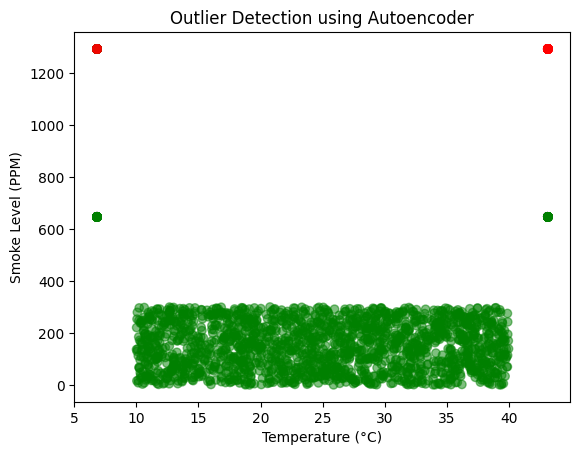

In [91]:
# التنبؤ بالقيم الشاذة
output = model(torch.tensor(X, dtype=torch.float32))  # Convert X to a tensor before passing it to the model
reconstruction_error = torch.mean((torch.tensor(X, dtype=torch.float32) - output) ** 2, dim=1)  # Convert X to tensor here as well

threshold = torch.quantile(reconstruction_error, 0.95)  # threshold استخدام 95% من الأخطاء ك

# تصنيف القيم كـ "Normal" أو "Outlier"
data['Outlier'] = ['Outlier' if error > threshold else 'Normal' for error in reconstruction_error]

outliers_data = data[data['Outlier'] == 'Outlier']
print("Outliers detected:")
print(outliers_data)

# رسم بياني لعرض القيم المتطرفة
plt.scatter(data['Temperature_C'], data['SmokeLevel_PPM'], c=data['Outlier'].map({'Normal': 'green', 'Outlier': 'red'}), alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Smoke Level (PPM)')
plt.title('Outlier Detection using Autoencoder')
plt.show()

Test Data with Predictions:
   Temperature_C  Humidity_Percentage  SmokeLevel_PPM  \
0             25                   50             250   
1             30                   70             600   
2             45                   80            1200   
3             15                   40             100   
4             35                   60             350   
5             20                   65             150   

   CarbonMonoxideLevel_PPM  Outlier  
0                        5   Normal  
1                       35   Normal  
2                       10  Outlier  
3                       30   Normal  
4                       20   Normal  
5                       25   Normal  


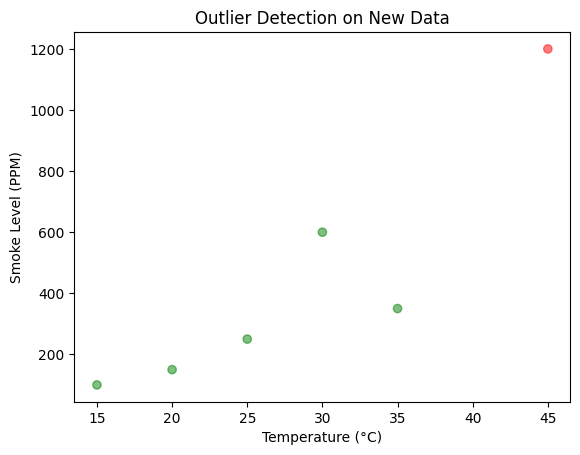

In [92]:
# البيانات الجديدة التي نرغب في اختبار النموذج عليها
new_data = pd.DataFrame({
    'Temperature_C': [25, 30, 45, 15, 35, 20],
    'Humidity_Percentage': [50, 70, 80, 40, 60, 65],
    'SmokeLevel_PPM': [250, 600, 1200, 100, 350, 150],
    'CarbonMonoxideLevel_PPM': [5, 35, 10, 30, 20, 25],
})

# فصل البيانات إلى X (الخصائص)
X_new = new_data[['Temperature_C', 'Humidity_Percentage', 'SmokeLevel_PPM', 'CarbonMonoxideLevel_PPM']].values

# تحويل البيانات الجديدة إلى PyTorch Tensors
X_new_tensor = torch.tensor(X_new, dtype=torch.float32)

# استخدام النموذج المدرب (من المثال السابق)
model.eval()  # تأكد من أن النموذج في وضع التقييم
with torch.no_grad():
    # التنبؤ (إعادة البناء)
    output = model(X_new_tensor)

    # حساب خطأ إعادة البناء
    reconstruction_error = torch.mean((X_new_tensor - output) ** 2, dim=1)

    threshold = torch.quantile(reconstruction_error, 0.95)

    predictions = (reconstruction_error > threshold).float()

# إضافة الأعمدة الجديدة للتنبؤ
new_data['Outlier'] = ['Normal' if pred == 0 else 'Outlier' for pred in predictions]

# طباعة النتائج الجديدة
print("Test Data with Predictions:")
print(new_data)

# رسم بياني لعرض القيم الشاذة مع البيانات الجديدة
plt.scatter(new_data['Temperature_C'], new_data['SmokeLevel_PPM'], c=new_data['Outlier'].map({'Normal': 'green', 'Outlier': 'red'}), alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Smoke Level (PPM)')
plt.title('Outlier Detection on New Data')
plt.show()


In [33]:
# ثبت المكاتب لو مش عندك
# pip install onnx
# pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 62.5 MB/s eta 0:00:00


In [93]:
import onnx
import onnxruntime as ort
import numpy as np

# تحميل النموذج من ONNX
onnx_model = onnx.load("anomaly_detector.onnx")

# التحقق من صحة النموذج
onnx.checker.check_model(onnx_model)

# إعداد ONNX Runtime
session = ort.InferenceSession("anomaly_detector.onnx")

# البيانات الجديدة لاختبار النموذج
new_data = np.array([[25, 50, 250, 5]], dtype=np.float32)  # بيانات جديدة (1 عينة)

# إدخال البيانات للنموذج
inputs = {session.get_inputs()[0].name: new_data}

# إجراء التنبؤ باستخدام النموذج
outputs = session.run(None, inputs)

# عرض النتيجة (التنبؤ بالـ Outlier => 1 أو Normal => 0 )
prediction = outputs[0]
print("Predicted Output:", *prediction)


Predicted Output: [0.]


In [77]:

# # إنشاء مدخل افتراضي لتصدير النموذج
# dummy_input = torch.randn(1, 4)  # افترض أن المدخل هو من 4 خصائص كما في X

# # اسم ملف ONNX
# onnx_filename = "anomaly_detector.onnx"

# # تصدير النموذج إلى ONNX
# torch.onnx.export(model, dummy_input, onnx_filename, input_names=["input"], output_names=["output"])

# print(f"تم حفظ النموذج في {onnx_filename}")


تم حفظ النموذج في anomaly_detector.onnx
